# Rai Live System Analysis

In this notebook, we read in the data that was generated and saved as a csv from the [TheGraphDataSetCreation](TheGraphDataSetCreation.ipynb) notebook and examine the following three areas:


## Rough internal notes:
* Correlation of RAI to Eth price moves - EthRai(marketPriceEth), RaiUSD(marketPriceUsd),EthRaiTWAP, EthUSD price moves. Pull volumne data as well if possible
    * $P$ = Vector of Prices
    * $P^+$ = $P$  + $\Delta P$
    * $\Delta P$ = matrix * $P$
    * $M$ = (Identity + matrix)*$P$
    * $P^+$ = $M$*$P$
    * Model of the vector autocorrelation - https://en.wikipedia.org/wiki/Vector_autoregression
    * Document how and why
    * Inference about how these things move
    * Could be a rich, multi-causal relationship
    * Should compare Rai results to Eth
    * System level price dynamics
    * Need to scale data to the same order prior to regressor
    * Extend auto correlation analysis to include other signals, like the fraction of rai debt ceiling available and fraction of rai available in the uniswap instance.
    * Goal is to make some statements about how Rai is actually being dictated by Ethereum price moves.
* Resource allocation efficiency wrt airdrop policy analysis - Dataset creation first then policy analysis
    * Reward Rules - https://gist.github.com/stefanionescu/e66204be990f4bc113a022341cb39186 
    * Are people acting differently based off of the reward policies? Do individual agents strategies make sense given their capital available. How well explained is the behavior by these rewards. Can we measure the behavior changes with the reward changes?
    * Need event data by address. Users can be LPs or minters, users as ethereum addresses. In uniswap and on the rai contract. 
    * Primary key user - primary key event id. 
    * Need a new query. 
    * Getting the agent activity
    * Build user event sequence dataset.
    * Make off of one user first. - Z ethereum address - 0xDF290293C4A4d6eBe38Fd7085d7721041f927E0a
    * Have Z confirm
    * Event sequence of: transaction sequence: rai/eth swaps, add liquidity to the ETH/RAI uni pair, open safe, lock eth, withdraw eth, draw RAI, repay RAI
    * Global state at the time of the event (uniswap and rai systems). Local state is Z's Safe state. 
    
#### Will be built off of agent, simplified prices system data, full system datasets created above
* Effective rate of return for RAI minters given error conditions 
* Slippage Rates relative to Uniswap
* Effective Rate paid for debt

   



In [270]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.tsa.api import VAR
from sklearn.preprocessing import StandardScaler
from math import sqrt

## Import data and add additional attributes

In [271]:
graphData = pd.read_csv('saved_results/RaiLiveGraphData.csv')
del graphData['Unnamed: 0']

In [272]:
graphData.head()

,blockNumber,erc20CoinTotalSupply,globalDebt,marketPriceEth,marketPriceUsd,redemptionPrice,redemptionRate,timestamp,redemptionPriceActual,redemptionRateActual,activeLiquidations,currentFsmUpdate,currentMedianizerUpdate,debtCeiling,liquidationsStarted,totalAnnualizedStabilityFee,totalCollateral,Eth_price
0,11857308,1988.440433,1988.577499,0.002589,4.670500,"{'block': '11849022', 'id': '0xe313271188492c4...",{'hourlyRate': '1'},1613338681,3.14,1.0,0,{'value': '1803.65643044'},{'value': '1803.65643044'},10000000.0,0,1.02,14.89236,1803.656430
1,11860793,2788.440433,2788.617717,0.002481,4.377049,"{'block': '11860755', 'id': '0x40066774f6fb7d3...",{'hourlyRate': '1'},1613384616,3.14,1.0,0,{'value': '1803.65643044'},{'value': '1763.97493608'},10000000.0,0,1.02,14.89236,1803.656430
2,11861040,2788.440433,2788.657935,0.002481,4.406833,"{'block': '11861008', 'id': '0x0d551e2a2d55fa8...",{'hourlyRate': '1'},1613387890,3.14,1.0,0,{'value': '1763.97493608'},{'value': '1775.97792296'},10000000.0,0,1.02,14.89236,1763.974936
3,11861337,2788.440433,2788.657935,0.002481,4.419266,"{'block': '11861237', 'id': '0x5c67dbb323db039...",{'hourlyRate': '1'},1613392101,3.14,1.0,0,{'value': '1763.97493608'},{'value': '1780.98836373'},10000000.0,0,1.02,14.89236,1763.974936
4,11861474,3048.440433,3048.645955,0.001769,3.194330,"{'block': '11861237', 'id': '0x5c67dbb323db039...",{'hourlyRate': '1'},1613394096,3.14,1.0,0,{'value': '1763.97493608'},{'value': '1805.79273513'},10000000.0,0,1.02,16.89236,1763.974936


In [273]:
graphData.describe()

,blockNumber,erc20CoinTotalSupply,globalDebt,marketPriceEth,marketPriceUsd,timestamp,redemptionPriceActual,redemptionRateActual,activeLiquidations,debtCeiling,liquidationsStarted,totalAnnualizedStabilityFee,totalCollateral,Eth_price
count,8.510000e+02,8.510000e+02,8.510000e+02,851.000000,851.000000,8.510000e+02,851.000000,851.000000,851.000000,8.510000e+02,851.000000,8.510000e+02,851.000000,851.000000
mean,1.197706e+07,3.325319e+07,3.370093e+07,0.001882,3.218255,1.614931e+09,3.065455,0.999955,0.030552,4.315426e+07,72.390129,1.020000e+00,152843.403241,1724.277462
std,6.749445e+04,1.420924e+07,1.433379e+07,0.000300,0.444691,8.979880e+05,0.049259,0.000059,0.230615,1.589553e+07,39.334022,1.155311e-14,64832.491014,155.493490
min,1.185731e+07,1.988440e+03,1.988577e+03,0.001600,2.850455,1.613339e+09,3.013686,0.999796,0.000000,1.000000e+07,0.000000,1.020000e+00,14.892360,1328.192602
25%,1.191878e+07,2.749865e+07,2.755863e+07,0.001671,3.009266,1.614156e+09,3.017865,0.999913,0.000000,3.286157e+07,50.000000,1.020000e+00,119777.894349,1586.828710
50%,1.197660e+07,3.463165e+07,3.549437e+07,0.001781,3.142389,1.614924e+09,3.047204,0.999961,0.000000,4.686430e+07,97.000000,1.020000e+00,176257.577038,1776.050000
75%,1.203514e+07,4.513489e+07,4.532411e+07,0.002053,3.265479,1.615705e+09,3.117719,1.000004,0.000000,5.727986e+07,101.000000,1.020000e+00,200198.029035,1823.690000
max,1.209544e+07,4.899876e+07,4.918825e+07,0.004474,8.055382,1.616506e+09,3.140000,1.000044,3.000000,5.727986e+07,105.000000,1.020000e+00,209393.009759,2032.578356


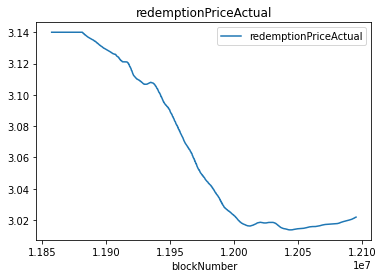

In [274]:
graphData.plot(x='blockNumber',y='redemptionPriceActual',kind='line',title='redemptionPriceActual')

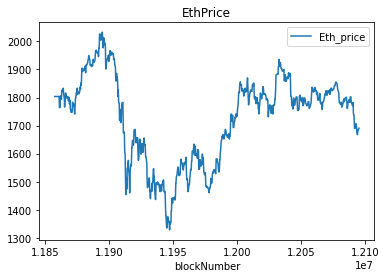

In [275]:
graphData.plot(x='blockNumber',y='Eth_price',kind='line',title='EthPrice')

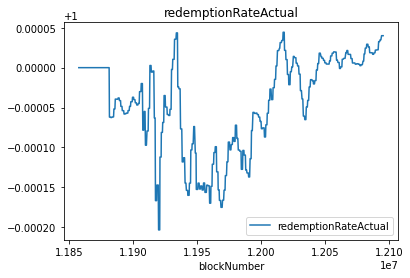

In [276]:
graphData.plot(x='blockNumber',y='redemptionRateActual',kind='line',title='redemptionRateActual')

In [277]:
graphData['error'] = graphData['redemptionPriceActual'] - graphData['marketPriceUsd']
graphData['error_integral'] = graphData['error'].cumsum()

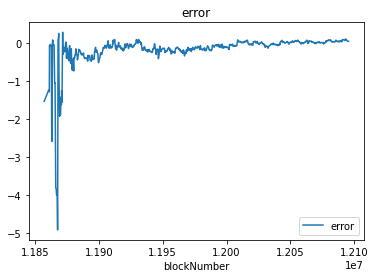

In [278]:
graphData.plot(x='blockNumber',y='error',kind='line',title='error')

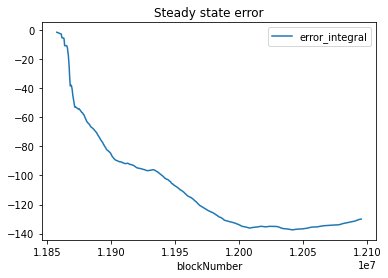

In [279]:
graphData.plot(x='blockNumber',y='error_integral',kind='line',title='Steady state error')

## Correlation of RAI to Eth price moves 

We are performing a vector autogression in order to determine if a casual or multi-casual relationship exists between Eth and Rai price moves. This will help use understand system level price dynamics of the Rai system.  

### Vector Autoregression 

Vector autoregression (VAR) is a type of statistical model used to capture the relationship between multiple time series signals as they change over time. VAR models are extensions of univaraite autoregression models allowing for multiivate rimme series.

Autogregressive models use lagged past values of the variable and have an order based on how many times the variable has been lagged. Lagged values help to determine if seasonality or reoccuring patterns exist in the data. 

For our VAR model, we will have a vector of prices, $P$ of the EthRai, EthRai(marketPriceEth),RaiUSD(marketPriceUsd), and EthUSD price moves

VAR models assume that the time series is stationary. Differenceing can be used to make the data stationary. Additionally, we need to scale the data to be the same scale for analysis. We will make stationary and then scale our data prior to model fitting.

  
# Deviration: 
* $P^+$ = $P$  + $\Delta P$
* $\Delta P$ = matrix * $P$
* $M$ = (Identity + matrix)*$P$
* $P^+$ = $M$*$P$




# TODO
    * Need to scale data to the same order prior to regressor
    * Make stationary
    * Extend auto correlation analysis to include other signals, like the fraction of rai debt ceiling available and fraction of rai available in the uniswap instance.
    * Goal is to make some statements about how Rai is actually being dictated by Ethereum price moves.
    * Re



In [280]:
P = graphData[['marketPriceEth','marketPriceUsd','Eth_price']]


In [281]:
P.describe()

,marketPriceEth,marketPriceUsd,Eth_price
count,851.000000,851.000000,851.000000
mean,0.001882,3.218255,1724.277462
std,0.000300,0.444691,155.493490
min,0.001600,2.850455,1328.192602
25%,0.001671,3.009266,1586.828710
50%,0.001781,3.142389,1776.050000
75%,0.002053,3.265479,1823.690000
max,0.004474,8.055382,2032.578356


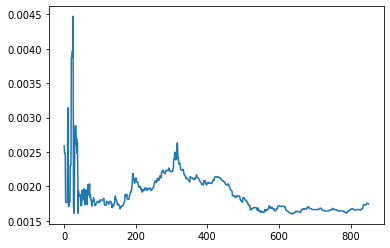

In [282]:
P.marketPriceEth.plot()

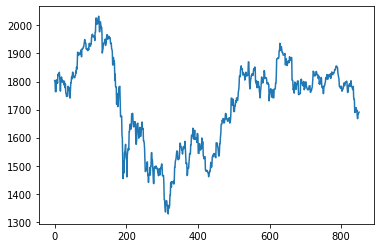

In [283]:
P.Eth_price.plot()

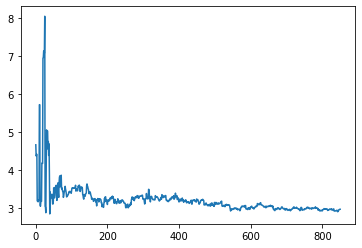

In [284]:
P.marketPriceUsd.plot()

In [285]:
## Difference 

P['marketPriceEth_log_differenced'] = np.log(P['marketPriceEth']).diff()
P['marketPriceUsd_log_differenced'] = np.log(P['marketPriceUsd']).diff()
P['Eth_price_log_differenced'] = np.log(P['Eth_price']).diff()

<ipython-input-285-d0dc44f6a4a5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  P['marketPriceEth_log_differenced'] = np.log(P['marketPriceEth']).diff()
<ipython-input-285-d0dc44f6a4a5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  P['marketPriceUsd_log_differenced'] = np.log(P['marketPriceUsd']).diff()
<ipython-input-285-d0dc44f6a4a5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

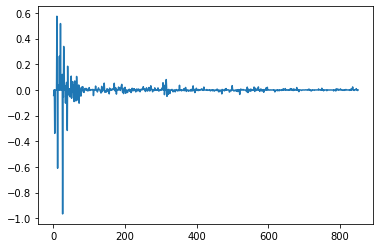

In [286]:
P.marketPriceEth_log_differenced.plot()

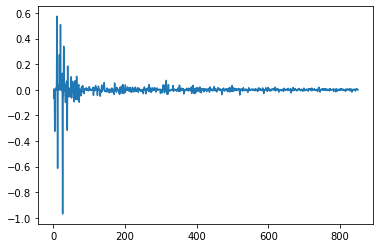

In [287]:
P.marketPriceUsd_log_differenced.plot()

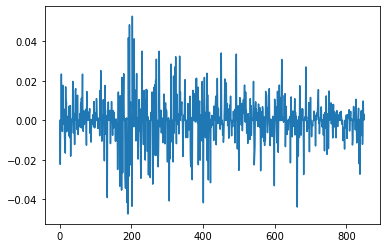

In [288]:
P.Eth_price_log_differenced.plot()

In [289]:
P.describe()

,marketPriceEth,marketPriceUsd,Eth_price,marketPriceEth_log_differenced,marketPriceUsd_log_differenced,Eth_price_log_differenced
count,851.000000,851.000000,851.000000,850.000000,850.000000,850.000000
mean,0.001882,3.218255,1724.277462,-0.000464,-0.000531,-0.000076
std,0.000300,0.444691,155.493490,0.055664,0.056014,0.010952
min,0.001600,2.850455,1328.192602,-0.966119,-0.970155,-0.047327
25%,0.001671,3.009266,1586.828710,-0.002737,-0.005004,-0.003049
50%,0.001781,3.142389,1776.050000,-0.000056,-0.000002,0.000000
75%,0.002053,3.265479,1823.690000,0.001473,0.004687,0.003741
max,0.004474,8.055382,2032.578356,0.574561,0.574204,0.052679


Standardize the data (rescale values to mean of a 0 and a standard deviation of 1). Standardization will move these different scales/order of magnitude to the same. 

In [290]:
# scaler objects
scalers = []
# features to scale
features = ['marketPriceEth_log_differenced','marketPriceUsd_log_differenced','Eth_price_log_differenced']
for i in features:
    # train the standardization
    scaler = StandardScaler()
    # prepare data for standardization
    values = P[i].values
    values = values.reshape((len(values), 1))
    scaler = scaler.fit(values)
    print('Mean: %f, StandardDeviation: %f' % (scaler.mean_, sqrt(scaler.var_)))
    scalers.append(scaler)
    string = i + '_standardized'
    P[string] = scaler.transform(values)

Mean: -0.000464, StandardDeviation: 0.055631
Mean: -0.000531, StandardDeviation: 0.055981
Mean: -0.000076, StandardDeviation: 0.010945


<ipython-input-290-2695daa484a7>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  P[string] = scaler.transform(values)
<ipython-input-290-2695daa484a7>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  P[string] = scaler.transform(values)
<ipython-input-290-2695daa484a7>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

The following code can be used to inverse the transform
```
inversed = scaler.inverse_transform(normalized)
```

In [291]:
P.describe()

,marketPriceEth,marketPriceUsd,Eth_price,marketPriceEth_log_differenced,marketPriceUsd_log_differenced,Eth_price_log_differenced,marketPriceEth_log_differenced_standardized,marketPriceUsd_log_differenced_standardized,Eth_price_log_differenced_standardized
count,851.000000,851.000000,851.000000,850.000000,850.000000,850.000000,8.500000e+02,8.500000e+02,8.500000e+02
mean,0.001882,3.218255,1724.277462,-0.000464,-0.000531,-0.000076,-2.460246e-18,7.428698e-19,1.859624e-17
std,0.000300,0.444691,155.493490,0.055664,0.056014,0.010952,1.000589e+00,1.000589e+00,1.000589e+00
min,0.001600,2.850455,1328.192602,-0.966119,-0.970155,-0.047327,-1.735828e+01,-1.732056e+01,-4.317092e+00
25%,0.001671,3.009266,1586.828710,-0.002737,-0.005004,-0.003049,-4.085865e-02,-7.989463e-02,-2.716629e-01
50%,0.001781,3.142389,1776.050000,-0.000056,-0.000002,0.000000,7.339013e-03,9.447990e-03,6.941278e-03
75%,0.002053,3.265479,1823.690000,0.001473,0.004687,0.003741,3.482399e-02,9.320664e-02,3.487620e-01
max,0.004474,8.055382,2032.578356,0.574561,0.574204,0.052679,1.033646e+01,1.026659e+01,4.819949e+00


In [292]:
P.fillna(0,inplace=True)

/home/aclarkdata/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [293]:
# instansiate the var model object from statsmodels
model = VAR(P[['marketPriceEth_log_differenced_standardized',
               'marketPriceUsd_log_differenced_standardized',
               'Eth_price_log_differenced_standardized']])

In [294]:
# calculate the best autocorrelation value
results = model.fit(maxlags=10, ic='aic')

In [295]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 23, Mar, 2021
Time:                     11:28:42
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -3.82180
Nobs:                     842.000    HQIC:                  -4.11320
Log likelihood:          -1692.36    FPE:                  0.0136478
AIC:                     -4.29425    Det(Omega_mle):       0.0123720
--------------------------------------------------------------------
Results for equation marketPriceEth_log_differenced_standardized
                                                    coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------------------------------
const                                                  0.015661         0.030208            0.518           0.604
L1.m

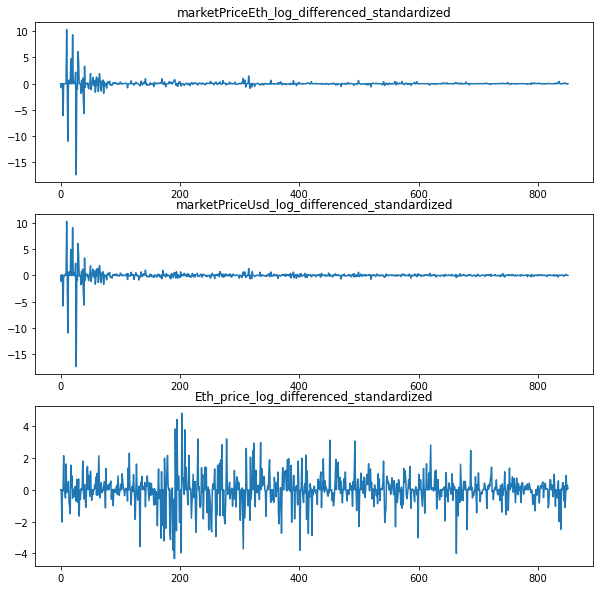

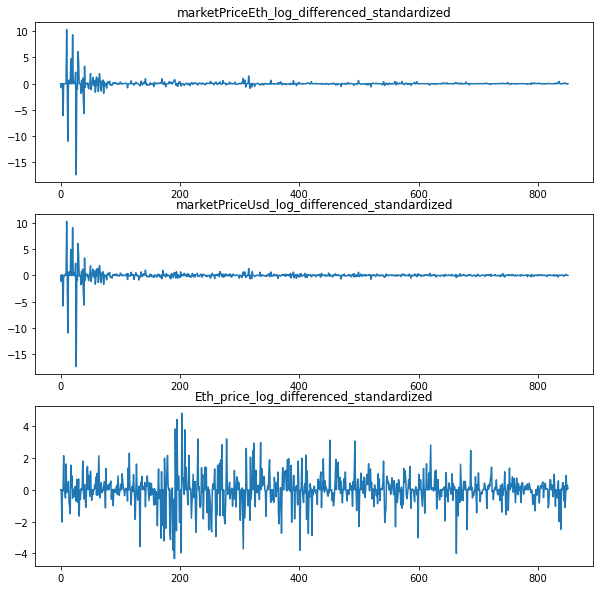

In [296]:
results.plot()

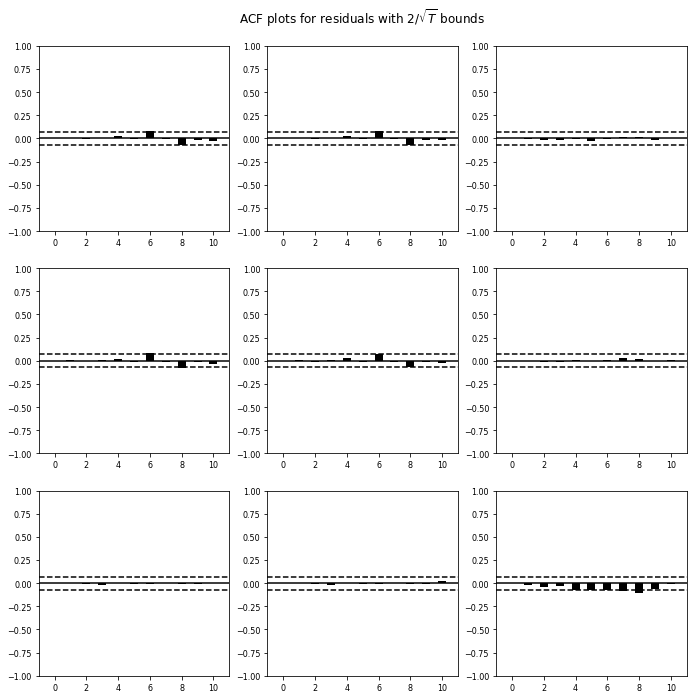

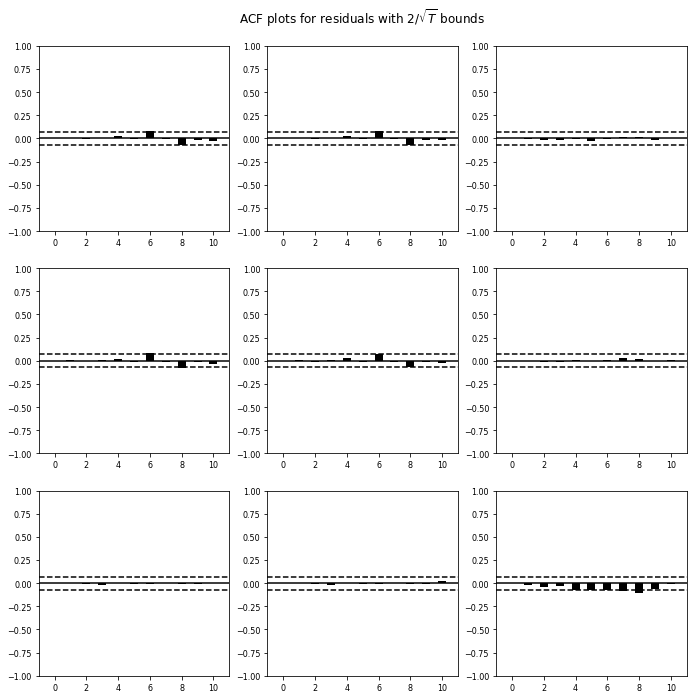

In [297]:
# plot the autocorrelation function
results.plot_acorr()

## Impulse Response Analysis

Impulse response is used in econometrics to study how the estimated responses of a variable to a unit impulse.


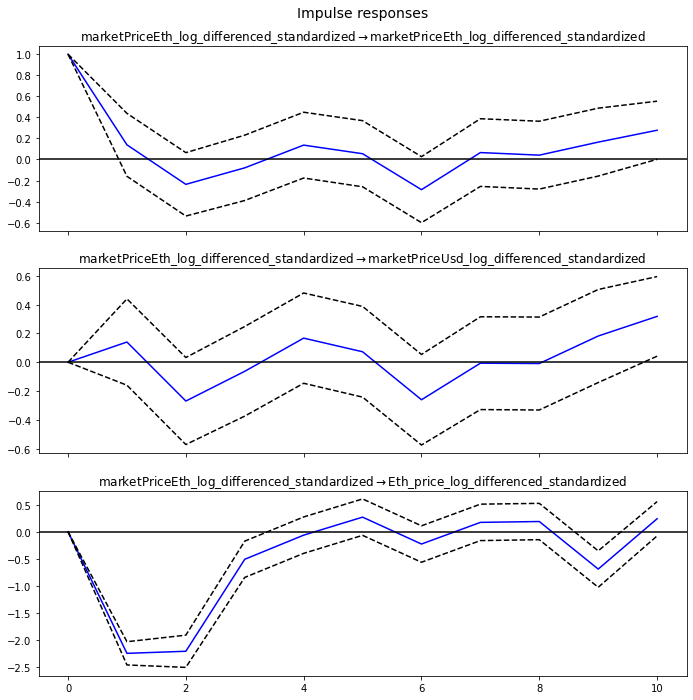

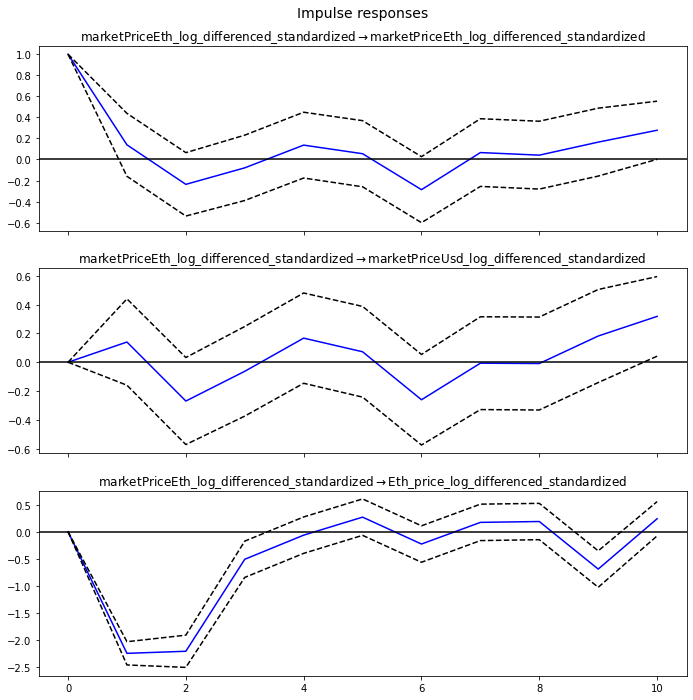

In [299]:
irf = results.irf(10)
irf.plot(impulse='marketPriceEth_log_differenced_standardized',orth=False)

Standard errors are plotted by default at the 95% significance level.

Cumulative effect:

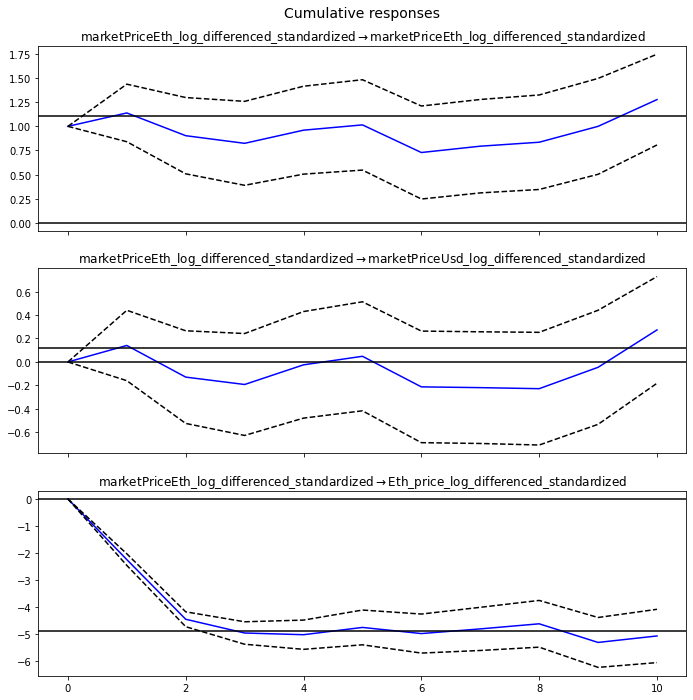

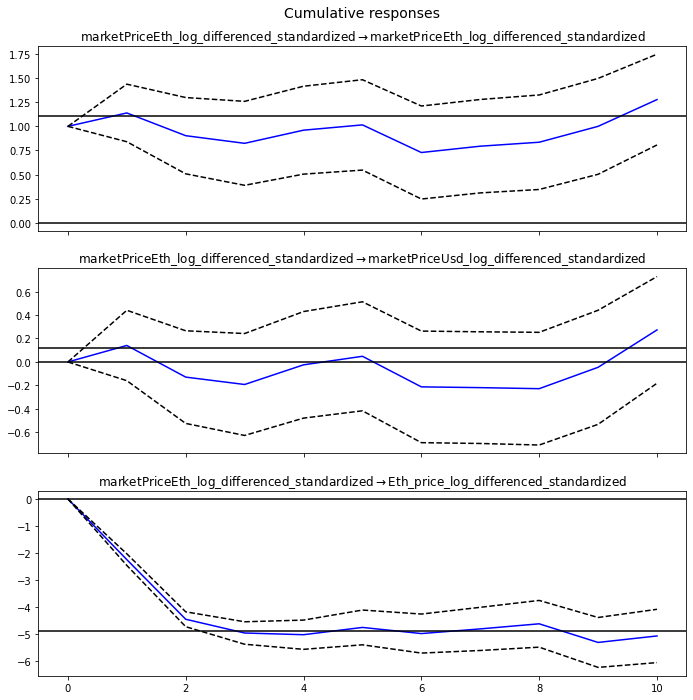

In [300]:
irf.plot_cum_effects(orth=False,impulse='marketPriceEth_log_differenced_standardized')

### Granger causality

Test to see if eth price is has any casual component for the Rai market price

In [301]:
results.test_causality(['marketPriceEth_log_differenced_standardized', 
                        'marketPriceUsd_log_differenced_standardized'],
                       'Eth_price_log_differenced_standardized', kind='f').summary()

Test statistic,Critical value,p-value,df
1.350,1.608,0.147,"(18, 2442)"


Based on the Granger Causality test, Eth_price_log_differenced_standardized does have a casually influence Rai price.

## Normality
The white noise component is assumed to be normally distributed. Results are more reliable when this assumption is met. We will test it below using the Jarque-Bera-test for normality.

In [302]:
results.test_normality().summary()

Test statistic,Critical value,p-value,df
2.458e+05,12.59,0.000,6


The results were not normal, which reduces the reliability of our assumptions. However, if this analysis was run after the initial price movements, the results would most likely be normal.

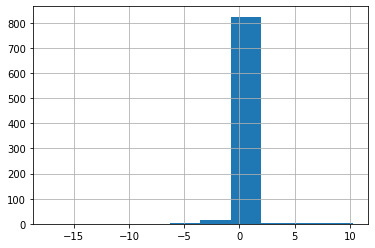

In [312]:
P.marketPriceUsd_log_differenced_standardized.hist()

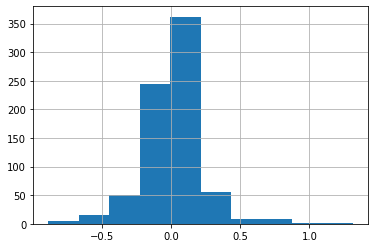

In [311]:
P.marketPriceUsd_log_differenced_standardized[100:].hist()

As you can see, if we skipped the first 100 data points, the data appears a lot more normal

## Conclusion

Based on our VAR analysis, Eth price does have an influence on the Rai price.